<H1>Applied Data Science Capstone Part 3</H1>

<H3>This is all the code from Part 1 and 2</H3>

In [1]:
#Installing needed packages

import numpy as np
import pandas as pd
import requests
import urllib.request
!pip install beautifulsoup4
from bs4 import BeautifulSoup
import io

import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

%matplotlib inline

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#Loading Wikipedia page
wiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
    
#save the HTML into variable
page = urllib.request.urlopen(wiki)

#srapping data into variable "soup"
soup = BeautifulSoup(page)

#Create Dataframe with scrapped data
wiki_table = soup.find('table', class_ = 'wikitable sortable')
A=[]
B=[]
C=[]
for row in wiki_table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells)==3: #Only extract table body not heading
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
CA_df=pd.DataFrame(A,columns=['PostalCode'])
CA_df['Borough']=B
CA_df['Neighborhood']=C

#Dropping rows with 'Not assigned' in column 'Borough'
indexNames = CA_df[ CA_df['Borough'] == 'Not assigned' ].index
CA_df.drop(indexNames , inplace=True)

#Reassigning 'Not assigned' Neighborhood names with 'Borough' values
CA_df.loc[CA_df['Neighborhood'].str.contains('Not'), 'Neighborhood'] = CA_df['Borough']

#Combine Neighborhoods if postal code is the same
CA_df=CA_df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()

#Last round of cleanup
CA_df.replace('\n','',regex=True,inplace=True)

#Importing Geospatial Coordinates
geo = pd.read_csv(io.StringIO(requests.get("https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv").content.decode('utf-8')))

#Merging the two data frames
CA_geo = pd.concat([CA_df, geo], axis=1, join='inner', sort=False)

#Delete the duplicated column
del CA_geo['Postal Code']

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

<H3>First, I check how the dataframe looks like</H3>

In [2]:
CA_geo.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<H3>Then, I start clustering using K-Means</H3>

In [4]:
from sklearn.cluster import KMeans

X = CA_geo[['Latitude','Longitude']].values

Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

<H3>I use the elbow method to determine what is the optimal ammount of clusters. Turns out it was 3.</H3>

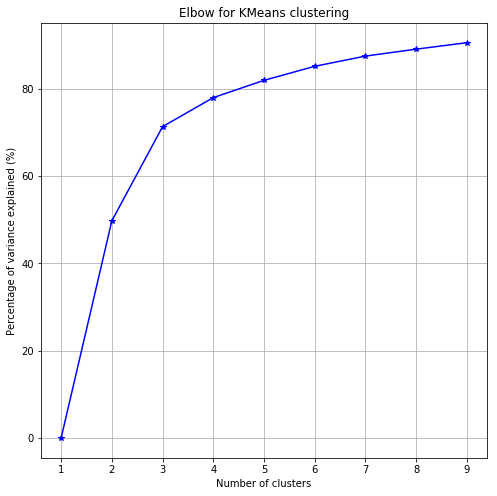

In [5]:
#Elbow method to determine optimal number of Ks

from scipy.spatial.distance import cdist, pdist

def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

<H3>I then train my model with 3 clusters</H3>

In [83]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

<H3>I add the categorization labels to a variable</H3>

In [15]:
labels=kmeans.labels_

<H3>And append those labels to my main data frame</H3>

In [16]:
CA_geo['Labels']=labels
CA_geo.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Labels
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,2
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,2
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2


<H3>Now, it's time to map my results and see how they look</H3>

In [82]:
# define the world map
world_map = folium.Map()

# define the world map centered around Canada with a higher zoom level
world_map = folium.Map(location=[43.72,-79.35], zoom_start=11.75)

# instantiate a feature group for the incidents in the dataframe
neighborhoods = folium.map.FeatureGroup()

#adding some cool colors to the map
folium.TileLayer('cartodbdark_matter').add_to(world_map)
colordict = ['lightblue','lightgreen','orange']

# loop through the neighborhoods and add each to the clusters feature group
for lat, lng, cluster, in zip(CA_geo.Latitude, CA_geo.Longitude, CA_geo.Labels):
    neighborhoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color=colordict[cluster-1],
            fill=True,
            fill_color=colordict[cluster-1],
            fill_opacity=0.3
        )
    )
    
       
    
# add clusters to map
world_map.add_child(neighborhoods)

<H3>Clusters look great! It appepars the most efficient way to group neighborhoods was "East", "Mid" and "West". Map looks great as well.</H3>